In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import os
import warnings
warnings.filterwarnings("ignore")
os.listdir("../input")



['image-colorization',
 'image-classification',
 'images',
 'intel-data-scene',
 'general100',
 'image-food']

**Now the image loading part**

In [2]:
def toArray(k):
    return np.array(list(k.getdata())).reshape(k.size[1], k.size[0], 3)

In [3]:
from sklearn.metrics import mean_absolute_error as mae 
from skimage.measure import compare_psnr as psnr

print(len(os.listdir("../input/images")))
print(len(os.listdir("../input/general100")))
print(len(os.listdir("../input/intel-data-scene/scene_classification/scene_classification/train")))
print(os.listdir("../input/image-colorization/ab/ab"))
print(os.listdir("../input/image-classification/images/images"))
print(len(os.listdir("../input/image-classification/images/images/art and culture")))
print(len(os.listdir("../input/image-classification/images/images/architecure")))
print(len(os.listdir("../input/image-classification/images/images/travel and  adventure")))
print(len(os.listdir("../input/image-classification/images/images/food and d rinks")))
print(os.listdir("../input/")) # image-food is tar and tars are not supported
train_data = []
for img_path in os.listdir("../input/images"):
    train_data += [Image.open('../input/images/'+img_path)]
for img_path in os.listdir("../input/general100"):
    train_data += [Image.open('../input/general100/'+img_path)]



47
50
24335
['ab1.npy', 'ab2.npy', 'ab3.npy']
['art and culture', 'architecure', 'travel and  adventure', 'food and d rinks']
8750
8661
8800
8782
['image-colorization', 'image-classification', 'images', 'intel-data-scene', 'general100', 'image-food']


In [4]:
for img_path in os.listdir("../input/image-classification/images/images/art and culture")[:150]:
    train_data += [Image.open('../input/image-classification/images/images/art and culture/'+img_path)]

(596, 451)


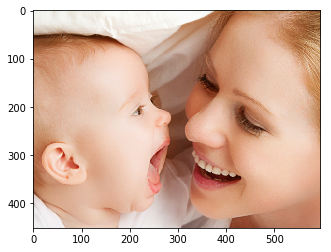

In [5]:
img=train_data[30]
print(img.size)
plot5= plt.imshow(img)

Personally I feel PSNR is a metric designed to assess signal legibility. Doesn't mean we can't use it, it just won't make much sense to people we'd present it to.

**Now comparison of different upsamplings** 

This should give an idea about what we want to beat.

Now I'll generate some training samples:

In [6]:
def imageListToNiceSamples(images, downscale_factor = 2, img_size = 40, n_convolutions = 4): 
    X = []
    Y = []
    for image in tqdm(images):
        cutoff = n_convolutions
        size = np.array(image.size)
        samples_from_image = size//img_size
        newimage = image.resize(size//downscale_factor, resample = Image.LANCZOS).resize(size, resample = Image.LANCZOS)
        try:
            image_array = toArray(image)
            newimage_array = toArray(newimage)
            if(image_array.shape[2]==1):
                continue
      
            X_temp = []
            Y_temp = []
          #  print(size, image.size, samples_from_image)
            for j in range(samples_from_image[0]):
                for i in range(samples_from_image[1]):
                    x = newimage_array[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size,:]/130-0.99
                    y = image_array[i*img_size+cutoff:(i+1)*img_size-cutoff,j*img_size+cutoff:(j+1)*img_size-cutoff,:]/130-0.99 #these fit for tanh and I think these should work better
                    y = image_array[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size,:]/130-0.99 # this for preserving image size (as now images are large padding boundaries won't change much)
                 #   x = newimage_array[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size,:]/255+0.005
                 #   y = image_array[i*img_size+cutoff:(i+1)*img_size-cutoff,j*img_size+cutoff:(j+1)*img_size-cutoff,:]/255+0.005 #these are for sigmoid or no activation - I've found someone not using it.
                    
                    X_temp+=[x.reshape(1,img_size,img_size,3)]
                    Y_temp+=[y.reshape(1,img_size,img_size,3)]
                    
            #X_temp_2 = np.concatenate([np.array(X_temp)[:,:,:,:,0],np.array(X_temp)[:,:,:,:,1],np.array(X_temp)[:,:,:,:,2]], axis=0)
            #Y_temp_2 = np.concatenate([np.array(Y_temp)[:,:,:,:,0],np.array(Y_temp)[:,:,:,:,1],np.array(Y_temp)[:,:,:,:,2]], axis=0)
            X+=[np.concatenate(X_temp, axis=0)] # these may look redundant, but they actually seem to help with memory:,1] use temp_2 for channel-separated
            X_temp = []
            
            Y+=[np.concatenate(Y_temp, axis=0)]
            Y_temp = []
        except:
            continue
    return(np.concatenate(X, axis=0), np.concatenate(Y, axis=0))

In [7]:
image_size = 224
n_convolutions = 3
downscale_factor = 2
X_train, y_train = imageListToNiceSamples(train_data, img_size = image_size, downscale_factor = downscale_factor, n_convolutions=n_convolutions)

100%|██████████| 247/247 [02:36<00:00,  1.58it/s]


At this point I'm trying to get anything to beat lanczos.
For the Keras model:

In [8]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Activation, Dropout, Lambda, MaxPooling2D, BatchNormalization, Reshape, Flatten, Input, Concatenate, Add, Conv2DTranspose
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [9]:
def getModel(lr = 0.002, dropout_rate = .2, input_dropout = .2, conv_layer_size = 64, image_size =40, downscale_factor =4, activation = 'sigmoid'): # encapsulation to facilitate skopt usage
    opt = Nadam(lr)

    inpt = Input((image_size,image_size, 3))
    
    mn2 = MobileNetV2(include_top=False, input_tensor = inpt)
    #mn2.summary()
    x = mn2.get_layer("Conv1_pad")(inpt)
    x = mn2.get_layer("Conv1")(x)
    x = mn2.get_layer("bn_Conv1")(x)
    x = mn2.get_layer("Conv1_relu")(x)
    x = mn2.get_layer("expanded_conv_depthwise")(x)
    x = mn2.get_layer("expanded_conv_depthwise_BN")(x)
    x = mn2.get_layer("expanded_conv_depthwise_relu")(x)
    x = mn2.get_layer("expanded_conv_project")(x)
    x = mn2.get_layer("expanded_conv_project_BN")(x)
    x = mn2.get_layer("block_1_expand")(x)
    x = mn2.get_layer("block_1_expand_BN")(x)
    x = mn2.get_layer("block_1_expand_relu")(x)
    x = mn2.get_layer("block_1_pad")(x)
    x = mn2.get_layer("block_1_depthwise")(x)
    x = mn2.get_layer("block_1_depthwise_BN")(x)
    x = mn2.get_layer("block_1_depthwise_relu")(x)
    x = mn2.get_layer("block_1_project")(x)
    y = mn2.get_layer("block_1_project_BN")(x)
    y = mn2.get_layer("block_2_expand")(y)
    y = mn2.get_layer("block_2_expand_BN")(y)
    y = mn2.get_layer("block_2_expand_relu")(y)
    y = mn2.get_layer("block_2_depthwise")(y)
    y = mn2.get_layer("block_2_depthwise_BN")(y)
    y = mn2.get_layer("block_2_depthwise_relu")(y)
    y = mn2.get_layer("block_2_project")(y)
    y = mn2.get_layer("block_2_project_BN")(y)
    z = mn2.get_layer("block_2_add")([y,x])
    
    aux_model = Model(inpt,z)
    for layer in aux_model.layers[:-3]:
        layer.trainable = False

    conv2dT = Conv2DTranspose(8,4, strides = 4)(z)
    conv2dT = BatchNormalization()(conv2dT)
    conv2dT = Activation('relu')(conv2dT)
    concat = Concatenate(axis = 3)([inpt, conv2dT])
    output = Activation('tanh')(Conv2D(3,3, padding='same')(concat))
                    
    
    
    model = Model(inpt,output)
    model.compile(loss = 'mae', optimizer = opt) 
    return(model)
    
X_train = X_train.reshape((-1,image_size,image_size,3))
y_train = y_train.reshape((-1,image_size,image_size,3))
print(X_train.shape)
print(y_train.shape)

(2043, 224, 224, 3)
(2043, 224, 224, 3)


In [10]:
mae(X_train.reshape(-1,image_size*image_size*3), y_train.reshape(-1,image_size*image_size*3)) # Because mse takes array of dim <=2

0.026259935722943523

In [11]:
model = getModel(dropout_rate = .35, input_dropout = 0.0, image_size = image_size, conv_layer_size = 8, downscale_factor = downscale_factor)
model.summary() #to give overview of number of params
stop = EarlyStopping(patience=100, restore_best_weights = True)
model.fit(X_train, y_train, batch_size = 32, epochs = 1000, validation_split = 0.1, callbacks = [stop], verbose = True)


Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 0s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[1][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[1]

I'm actually surprised. Expected it to just learn the identity function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


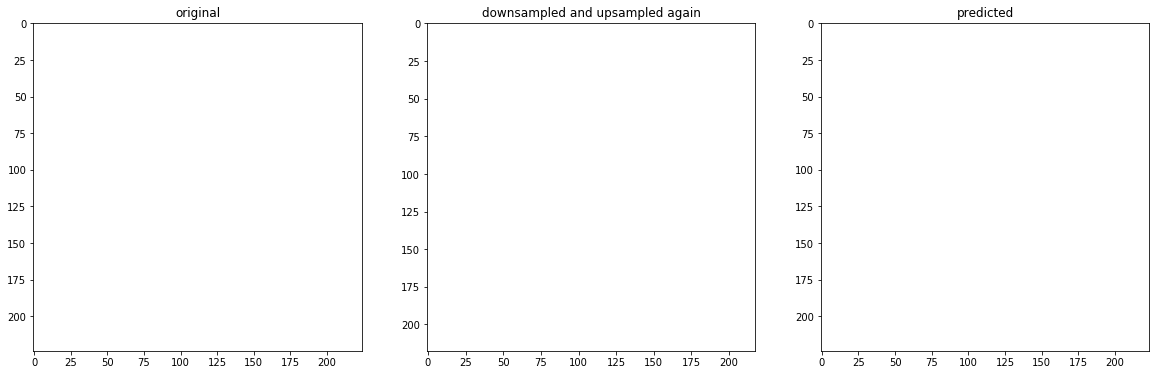

In [12]:
comp = plt.figure(figsize = (20,150))
m=1
for n in range(m):
    im = model.predict(np.array([X_train[n*100]]))+0.99*130
    comp.add_subplot(m+1,3,1+n*3, title = 'original')
    plt.imshow(y_train[n*100].reshape((image_size,image_size,3))+0.99*130)
    comp.add_subplot(m+1,3,2+n*3, title = 'downsampled and upsampled again')
    plt.imshow(X_train[n*100].reshape((image_size,image_size,3))[3:image_size-3,3:image_size-3]+0.99*130)
    comp.add_subplot(m+1,3,3+n*3, title = 'predicted')
    plt.imshow(im[0].reshape((image_size,image_size,3))+0.99*130)
plt.show()


In [13]:
def getModel(lr = 0.002, dropout_rate = .2, input_dropout = .2, conv_layer_size = 64, image_size =40, downscale_factor =4, activation = 'sigmoid'): # encapsulation to facilitate skopt usage
    opt = Nadam(lr)

    inpt = Input((image_size,image_size, 3))
    
    mn2 = MobileNetV2(include_top=False, input_tensor = inpt)
    #mn2.summary()
    x = mn2.get_layer("Conv1_pad")(inpt)
    x = mn2.get_layer("Conv1")(x)
    x = mn2.get_layer("bn_Conv1")(x)
    x = mn2.get_layer("Conv1_relu")(x)
    x = mn2.get_layer("expanded_conv_depthwise")(x)
    x = mn2.get_layer("expanded_conv_depthwise_BN")(x)
    x = mn2.get_layer("expanded_conv_depthwise_relu")(x)
    x = mn2.get_layer("expanded_conv_project")(x)
    x = mn2.get_layer("expanded_conv_project_BN")(x)
    x = mn2.get_layer("block_1_expand")(x)
    x = mn2.get_layer("block_1_expand_BN")(x)
    x = mn2.get_layer("block_1_expand_relu")(x)
    x = mn2.get_layer("block_1_pad")(x)
    x = mn2.get_layer("block_1_depthwise")(x)
    x = mn2.get_layer("block_1_depthwise_BN")(x)
    x = mn2.get_layer("block_1_depthwise_relu")(x)
    x = mn2.get_layer("block_1_project")(x)
    y = mn2.get_layer("block_1_project_BN")(x)
    y = mn2.get_layer("block_2_expand")(y)
    y = mn2.get_layer("block_2_expand_BN")(y)
    y = mn2.get_layer("block_2_expand_relu")(y)
    y = mn2.get_layer("block_2_depthwise")(y)
    y = mn2.get_layer("block_2_depthwise_BN")(y)
    y = mn2.get_layer("block_2_depthwise_relu")(y)
    y = mn2.get_layer("block_2_project")(y)
    y = mn2.get_layer("block_2_project_BN")(y)
    z = mn2.get_layer("block_2_add")([y,x])
    
    aux_model = Model(inpt,z)
    for layer in aux_model.layers[:-6]:
        layer.trainable = False

    conv2dT = Conv2DTranspose(8,4, strides = 4)(z)
    conv2dT = BatchNormalization()(conv2dT)
    conv2dT = Activation('relu')(conv2dT)
    concat = Concatenate(axis = 3)([inpt, conv2dT])
    output = Activation('tanh')(Conv2D(3,3, padding='same')(concat))
                    
    
    
    model = Model(inpt,output)
    model.compile(loss = 'mae', optimizer = opt) 
    return(model)
    
X_train = X_train.reshape((-1,image_size,image_size,3))
y_train = y_train.reshape((-1,image_size,image_size,3))
print(X_train.shape)
print(y_train.shape)

(2043, 224, 224, 3)
(2043, 224, 224, 3)


In [14]:
model = getModel(dropout_rate = .35, input_dropout = 0.0, image_size = image_size, conv_layer_size = 8, downscale_factor = downscale_factor)
model.summary() #to give overview of number of params
stop = EarlyStopping(patience=100, restore_best_weights = True)
model.fit(X_train, y_train, batch_size = 32, epochs = 1000, validation_split = 0.1, callbacks = [stop], verbose = True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[1][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[1][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [15]:
#from skopt import gp_minimize
#from skopt.space import Real, Integer
#dropout_rate_space = Real(low = 0.0, high = 0.7)
#mid_layer_size_space = Integer(low = 16, high = 512)
#def f(v):
#    model = getModel(dropout_rate = v[0], mid_layer_size= v[1])
#    model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_split = 0.2, callbacks = [stop], verbose = False)
#    return(mse(model.predict(X_train).reshape(-1,(image_size-2-2*n_convolutions)**2*3), y_train.reshape(-1,(image_size-2-2*n_convolutions)**2*3)) )

In [16]:
#res = gp_minimize(f, [dropout_rate_space, mid_layer_size_space],
#                  n_calls = 50, n_random_starts = 6, verbose = True
#                 )
#print(res.v)